In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output = [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circ_truseq_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circ_nextera/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circ_truseq/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circSTAMP_iter1/output'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]

In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    circ_df['full_id']=circ_df['circ_id']+':'+circ_df['strand']
    
    junc_ratio_tbl.append(circ_df.set_index('full_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('full_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('full_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))

In [4]:
stats_df = pd.concat(stats, axis = 1).T

In [5]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [6]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [7]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [8]:
rename_dict = {'HEK_JC_rar11':'rar11_JC_rep2', 
               'Exo05': 'Exo05', 
               'Exo10': 'Exo10',
               'HEK_rar11': 'rar11_rep2', 
               'EV_rar11': 'rar11_rep2-EV', 
               'TOB2_rar11': 'rar11_rep2-TOB2',
               'EV_rz': 'rz-EV', 
               'HEK_rar': 'rar_rep2', 
               'TOB2_rz': 'rz-TOB2', 
               'HEK_JC_rar': 'rar_JC', 
               'RBM15_rz': 'rz-RBM15',
               'circseq-bm-rar19-nxt': 'rar19', 
               'circseq-bm-rar11-nxt': 'rar11_rep1', 
               'circseq-bm-rar': 'rar_rep1',
               'circseq-bm-arr': 'arr', 
               'circseq-bm-rz': 'rz_rep1', 
               'APO-50-A': 'polyA-APO-50', 
               'APO-50-R': 'RNase-APO-50', 
               'HuR-noD-A': 'polyA-HuR-0',
               'HuR-50-R': 'RNase-HuR-0', 
               'HuR-1-A': 'polyA-HuR-1000', 
               'APO-noD-R': 'RNase-APO-0', 
               'HuR-1-R': 'RNase-HuR-1000', 
               'APO-1-R': 'RNase-APO-1000',
               'APO-noD-A': 'polyA-APO-0'}

In [9]:
group_color = {'rar11_JC': 'tomato',
              'rar11': 'orange',
              
              'rz': 'mediumorchid', 
              'rar': 'seagreen',
               'rar_JC': 'limegreen',
              'arr': 'royalblue'}

In [10]:
stats_df = stats_df.rename(rename_dict).sort_index()

In [11]:
figure1_sets = [ 
              'rz_rep1','rz-EV',
             'arr',
              'rar_rep1', 'rar_rep2',
            'rar_JC',
              'rar11_rep1','rar11_rep2', 'rar11_rep2-EV',
              'rar11_JC_rep2'
             ]

In [12]:
figure1_colors = [group_color[c.split('-')[0].split('_rep')[0]] for c in figure1_sets]

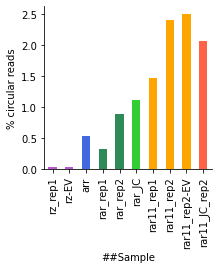

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
(stats_df.loc[figure1_sets, 'frac_circular']*100).plot.bar(
    color = figure1_colors, figsize = (3,3))
plt.ylabel('% circular reads')
sns.despine()

In [14]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = [rename_dict[c] for c in names]

In [15]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = [rename_dict[c] for c in names]

In [16]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = [rename_dict[c] for c in names]

In [17]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = [rename_dict[c] for c in names]

In [18]:
counts.div(counts.sum(axis = 0), axis = 1)

,rar11_JC_rep2,Exo05,rar11_rep2,rar11_rep2-EV,rar11_rep2-TOB2,Exo10,rz-EV,rar_rep2,rz-TOB2,rar_JC,...,rz_rep1,polyA-APO-50,RNase-APO-50,polyA-HuR-0,RNase-HuR-0,polyA-HuR-1000,RNase-APO-0,RNase-HuR-1000,RNase-APO-1000,polyA-APO-0
exon,0.733798,0.887250,0.730711,0.740856,0.750630,0.861983,0.849087,0.801782,0.856666,0.834013,...,0.834914,0.861439,0.797927,0.864232,0.843422,0.843844,0.818194,0.860370,0.796605,0.835685
intron,0.245823,0.092729,0.249367,0.230199,0.221225,0.118182,0.139585,0.184474,0.130532,0.155733,...,0.155601,0.132116,0.189788,0.132022,0.147306,0.138138,0.171479,0.127310,0.192429,0.157258
intergenic,0.010540,0.005269,0.010181,0.014588,0.013428,0.003306,0.007426,0.009264,0.007654,0.007308,...,0.006500,0.006445,0.007742,0.002809,0.007348,0.003003,0.006560,0.008214,0.006953,0.005040
antisense,0.009768,0.014752,0.009624,0.014247,0.014611,0.016529,0.003776,0.004403,0.005010,0.002889,...,0.002852,NaN,0.004455,0.000936,0.001924,0.015015,0.003767,0.004107,0.004013,0.002016
Unknown,0.000069,NaN,0.000117,0.000111,0.000106,NaN,0.000126,0.000076,0.000139,0.000057,...,0.000133,NaN,0.000088,NaN,NaN,NaN,NaN,NaN,NaN,NaN


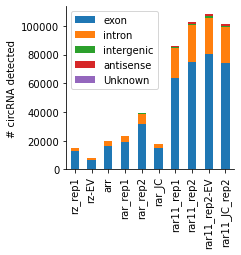

In [19]:

counts.loc[:, figure1_sets].T.plot.bar(stacked = True, figsize = (3,3))
plt.ylabel('# circRNA detected')
sns.despine()

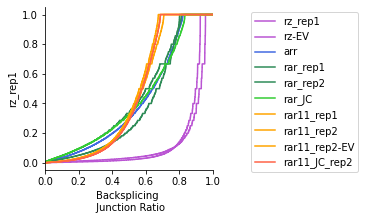

In [20]:
f, ax = plt.subplots(figsize = (3,3))
for col, color in zip(figure1_sets, figure1_colors):
    ax = sns.ecdfplot(data =junc[col].to_frame(), y = col, ax = ax, label = col, color = color)
    ax.set_xlabel('Backsplicing \n Junction Ratio')
ax.legend(bbox_to_anchor = (1.2,1))
#sns.move_legend(ax, "center right")
sns.despine()

# The design of primer


In [21]:
# calculate RPKM from bsj

In [22]:
bsj_cpm = (bsj.div(stats_df['##Mapped_Reads'], axis = 1)*(10**6)).fillna(0)

In [23]:
#rpkm = mapped to transcript/(total reads*transcript_langth)

In [24]:
# make sets
circname = {}
for fname in circ_quant_output:
    name = rename_dict[os.path.basename(fname).replace('.gtf', '')]
    circ_df, stat = read_ciri_gtf(fname)
    circ_df['full_id']=circ_df['circ_id']+':'+circ_df['strand']
    circname[name] = set(circ_df['full_id'])
rar11_reproducible = circname['rar11_rep2'].intersection(circname['rar11_rep1'])
rar_reproducible = circname['rar_rep1'].intersection(circname['rar_rep2'])
rz_reproducible = circname['rz_rep1'].intersection(circname['rz-EV'])
arr = circname['arr']

In [25]:
rar11_unique = rar11_reproducible-rar_reproducible-arr
rar_unique = rar_reproducible - rar11_reproducible - arr
arr_unique = arr - rar11_reproducible-rar_reproducible

common = set(rar11_reproducible).intersection(rar_reproducible).intersection(arr)
common_only_enrich = common - rz_reproducible
common_rz = common.intersection(rz_reproducible)

In [26]:
len(rar11_unique), len(rar_unique), len(arr_unique), len(common_only_enrich), len(common_rz)

(31583, 1411, 7605, 3514, 964)

In [27]:
bsj_cpm

,Exo05,Exo10,RNase-APO-0,RNase-APO-1000,RNase-APO-50,RNase-HuR-0,RNase-HuR-1000,arr,polyA-APO-0,polyA-APO-50,...,rar11_rep2-EV,rar11_rep2-TOB2,rar19,rar_JC,rar_rep1,rar_rep2,rz-EV,rz-RBM15,rz-TOB2,rz_rep1
chr1:633563|634095:-,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.068125,0.130989,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:633567|634095:-,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.092784,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:746695|749381:-,0.0,0.0,0.194108,0.0,0.176268,0.0,0.0,0.029723,0.000000,0.0,...,0.586926,0.414799,0.026832,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:781937|804966:+,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:803567|804840:+,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:19360824|19360991:+,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.006635,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX:23783686|23783883:+,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.006635,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX:109644045|109644186:-,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.006635,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrX:129488937|129489081:-,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.006635,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def find_expression_in_group(group, cols, n = 3):
    bsj_cpm['avg_cpm']=bsj_cpm[cols].mean(axis = 1)
    bsj_cpm['stderr_cpm']=bsj_cpm[cols].std(axis = 1)/bsj_cpm['avg_cpm']
    
    sub = bsj_cpm.loc[bsj_cpm.index.isin(group)].copy()
    
    # find the most table, least std
    sub['avg_cpm_bins'] = pd.qcut(sub['avg_cpm'],q = 8, duplicates = 'drop')
    print(sub['avg_cpm_bins'].unique())
    
    groups = []
    for cpm_bin, cpm_group in sub.groupby(by = 'avg_cpm_bins'):
        selected = cpm_group.loc[cpm_group['avg_cpm'].rank(ascending = False, method = 'dense')<=n]
        groups.append(selected.iloc[:n])
        
        
    
    return pd.concat(groups, axis = 0)
    

In [34]:
selected = []
for group, name, col in zip([rar11_unique, rar_unique, arr_unique, common_only_enrich, common_rz],
                       ['rar11_unique','rar_unique', 'arr_unique', 'common_only_enrich', 'common_rz'],
                        [['rar11_rep2', 'rar11_rep1'],
                        ['rar_rep1', 'rar_rep2'],
                         ['arr'],
                         ['rar11_rep2', 'rar11_rep1', 'rar_rep1', 'rar_rep2', 'rz_rep1', 'rz-EV', 'arr'],
                         ['rar11_rep2', 'rar11_rep1', 'rar_rep1', 'rar_rep2', 'rz_rep1', 'rz-EV', 'arr','rz_rep1', 'rz-EV']]
                           ):

    df = find_expression_in_group(group, col)
    df['cpm_estimated_from'] = ','.join(col)
    df['group'] = name
    selected.append(df)
selected = pd.concat(selected, axis = 0)

[(0.0642, 0.11], (0.11, 24.034], (0.011, 0.0169], (0.0444, 0.0642], (0.0324, 0.0444], (0.00279, 0.011], (0.0237, 0.0324], (0.0169, 0.0237]]
Categories (8, interval[float64]): [(0.00279, 0.011] < (0.011, 0.0169] < (0.0169, 0.0237] < (0.0237, 0.0324] < (0.0324, 0.0444] < (0.0444, 0.0642] < (0.0642, 0.11] < (0.11, 24.034]]
[(0.0391, 0.0497], (0.0156, 0.0219], (0.0497, 0.061], (0.0219, 0.0278], (0.0331, 0.0391], (0.0828, 0.364], (0.061, 0.0828], (0.0278, 0.0331]]
Categories (8, interval[float64]): [(0.0156, 0.0219] < (0.0219, 0.0278] < (0.0278, 0.0331] < (0.0331, 0.0391] < (0.0391, 0.0497] < (0.0497, 0.061] < (0.061, 0.0828] < (0.0828, 0.364]]
[(0.008910000000000001, 0.0198], (0.0594, 0.0793], (0.0198, 0.0297], (0.0793, 0.119], (0.119, 1.209], (0.0396, 0.0594], (0.0297, 0.0396]]
Categories (7, interval[float64]): [(0.008910000000000001, 0.0198] < (0.0198, 0.0297] < (0.0297, 0.0396] < (0.0396, 0.0594] < (0.0594, 0.0793] < (0.0793, 0.119] < (0.119, 1.209]]
[(0.312, 6.838], (0.0634, 0.0818], 

In [35]:
from Bio import SeqIO
from Bio.Seq import Seq


In [36]:
def find_BSJ_sequence(rec, strand, length = 150):
    first_half = str(rec.seq)[:int(len(rec.seq)/2)]
    second_half = str(rec.seq)[int(len(rec.seq)/2):]
    assert first_half == second_half
    
    plus_strand_upstream = Seq(first_half[-length:])
    plus_strand_downstream = Seq(second_half[:length])
    
    if strand == '-':
        upstream = plus_strand_downstream.reverse_complement()
        downstream = plus_strand_upstream.reverse_complement()
        
    elif strand == '+':
        upstream = plus_strand_upstream
        downstream = plus_strand_downstream
    
    return str(upstream), str(downstream)

In [37]:

selected_index_wo_strand = pd.Series(selected.index).apply(lambda i: ':'.join(i.split(':')[:-1])).tolist()
record_id_to_index = dict(zip(selected_index_wo_strand, selected.index.tolist()))

In [38]:
f = SeqIO.parse('/home/hsher/scratch/circ_nextera_iter2/output/circ/compendium.fa',
               format = 'fasta')
for rec in f:
    if rec.id in selected_index_wo_strand:
        index = record_id_to_index[rec.id]
        strand = index.split(':')[-1]
        fiveprime, threeprime = find_BSJ_sequence(rec, strand)
        selected.loc[index, '5prime_to_BSJ'] = fiveprime
        selected.loc[index, '3prime_to_BSJ'] = threeprime
    

In [39]:
selected

,Exo05,Exo10,RNase-APO-0,RNase-APO-1000,RNase-APO-50,RNase-HuR-0,RNase-HuR-1000,arr,polyA-APO-0,polyA-APO-50,...,rz-RBM15,rz-TOB2,rz_rep1,avg_cpm,stderr_cpm,avg_cpm_bins,cpm_estimated_from,group,5prime_to_BSJ,3prime_to_BSJ
chr1:2150790|2156092:+,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.010575,0.853056,"(0.00279, 0.011]","rar11_rep2,rar11_rep1",rar11_unique,CCTGTGAGGAGCATTCGGGAGCCTCATTACCACTCCCTGGTTTCTA...,GACCTTAAGCCAGTTATCGATGGGATGGATGGAATCAAAATCTCTC...
chr1:6531968|6549698:-,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.010575,0.853056,"(0.00279, 0.011]","rar11_rep2,rar11_rep1",rar11_unique,TTAAATGTCTACTTACCTTGTTGTGATTTGCCTTTCAGAGAGTCAC...,ATGACAGGCGTTGGTCGATGCAGAATTTTTCTCCTCAGTGTTCCAT...
chr1:19169435|19185286:-,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.010978,0.333067,"(0.00279, 0.011]","rar11_rep2,rar11_rep1",rar11_unique,GTGTCGTTCCTTCTTTCTTGTGATGATTCCTTGTCCTTTCTGTCGC...,ACGATGACAGTGAGCCTATTTTGGGGCAATGGTTTGAGGAGACTAT...
chr1:1789053|1790596:-,0.000000,0.0,0.010492,0.000000,0.010683,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.016870,0.007095,"(0.011, 0.0169]","rar11_rep2,rar11_rep1",rar11_unique,GTGCTGACCAGGAGCTCATGACTTACTCCCATGACAACATCATCTG...,TGCCCTGTGGGACATCGAGACCGGCCAGCAGACGACCACGTTTACC...
chr1:1815601|1839238:-,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.016870,0.007095,"(0.011, 0.0169]","rar11_rep2,rar11_rep1",rar11_unique,CGTGGGCATGAGCAGGATGCTGCTTGTTACATTCAGGGGCTGCTCT...,ACAAATTTACATGTATTGGAGACCAGACCAGAAGCCCTTCTGAATT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr5:79640851|79669028:+,0.000000,0.0,0.125908,0.335439,0.000000,0.000000,0.000000,0.614268,0.0,0.000000,...,0.000000,0.000000,0.032990,0.766225,1.566505,"(0.462, 0.768]","rar11_rep2,rar11_rep1,rar_rep1,rar_rep2,rz_rep...",common_rz,TTCTTTTTGACAGGAGTCTTTTAGTCCTGCTATACAGCTGCACCTT...,TTGAGTCAGCAGATACTGGAGTTATTTGAAACATGTCAGCAGCAAA...
chr10:94441896|94474783:+,0.000000,0.0,0.115416,0.273321,0.112170,0.199500,0.027798,0.099076,0.0,0.000000,...,0.019132,0.071939,0.038488,0.766149,1.509867,"(0.462, 0.768]","rar11_rep2,rar11_rep1,rar_rep1,rar_rep2,rz_rep...",common_rz,GTTTCTGCATAAGGTATGTTTTAATTTACTCTAGGAATATGAAGCA...,AAACCTTTTTCCAAAAAGGACAAAGGAACTCAAATCAGTTGTCCAT...
chr4:185247294|185267155:+,0.129783,0.0,0.000000,3.696040,0.000000,0.000000,0.016679,4.943868,0.0,0.000000,...,0.363499,0.197833,0.203436,5.880546,1.462774,"(0.768, 10.915]","rar11_rep2,rar11_rep1,rar_rep1,rar_rep2,rz_rep...",common_rz,TTACATTAACCAAATGCTGCTTGCCCAGCTGGCGTACAGAGAGCAA...,AGTCCTGTGTATGGAAACTCACATGAGTCAGCTCAGTCTAGAAGGG...
chr5:137985257|137988315:-,0.000000,0.0,3.079505,4.329647,4.540224,0.000000,0.088955,1.842804,0.0,0.015258,...,0.325236,0.215818,0.368384,10.914831,1.727141,"(0.768, 10.915]","rar11_rep2,rar11_rep1,rar_rep1,rar_rep2,rz_rep...",common_rz,TTAAACTTCATCCCTAGGATTGATATTGCTGATGATATTATTAATG...,CACCCATATATCTCCCATCAGCATCCTACCAGCCTCTACAGAGTAA...


In [41]:
selected.loc[selected['group']=='rar11_unique']

,Exo05,Exo10,RNase-APO-0,RNase-APO-1000,RNase-APO-50,RNase-HuR-0,RNase-HuR-1000,arr,polyA-APO-0,polyA-APO-50,...,rz-RBM15,rz-TOB2,rz_rep1,avg_cpm,stderr_cpm,avg_cpm_bins,cpm_estimated_from,group,5prime_to_BSJ,3prime_to_BSJ
chr1:2150790|2156092:+,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010575,0.853056,"(0.00279, 0.011]","rar11_rep2,rar11_rep1",rar11_unique,CCTGTGAGGAGCATTCGGGAGCCTCATTACCACTCCCTGGTTTCTA...,GACCTTAAGCCAGTTATCGATGGGATGGATGGAATCAAAATCTCTC...
chr1:6531968|6549698:-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010575,0.853056,"(0.00279, 0.011]","rar11_rep2,rar11_rep1",rar11_unique,TTAAATGTCTACTTACCTTGTTGTGATTTGCCTTTCAGAGAGTCAC...,ATGACAGGCGTTGGTCGATGCAGAATTTTTCTCCTCAGTGTTCCAT...
chr1:19169435|19185286:-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010978,0.333067,"(0.00279, 0.011]","rar11_rep2,rar11_rep1",rar11_unique,GTGTCGTTCCTTCTTTCTTGTGATGATTCCTTGTCCTTTCTGTCGC...,ACGATGACAGTGAGCCTATTTTGGGGCAATGGTTTGAGGAGACTAT...
chr1:1789053|1790596:-,0.000000,0.000000,0.010492,0.000000,0.010683,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016870,0.007095,"(0.011, 0.0169]","rar11_rep2,rar11_rep1",rar11_unique,GTGCTGACCAGGAGCTCATGACTTACTCCCATGACAACATCATCTG...,TGCCCTGTGGGACATCGAGACCGGCCAGCAGACGACCACGTTTACC...
chr1:1815601|1839238:-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016870,0.007095,"(0.011, 0.0169]","rar11_rep2,rar11_rep1",rar11_unique,CGTGGGCATGAGCAGGATGCTGCTTGTTACATTCAGGGGCTGCTCT...,ACAAATTTACATGTATTGGAGACCAGACCAGAAGCCCTTCTGAATT...
chr1:2393270|2403081:+,0.000000,0.000000,0.005246,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016382,1.121496,"(0.011, 0.0169]","rar11_rep2,rar11_rep1",rar11_unique,ATGTATAGAAAAGATGGGGGACCTTTGGCCGCTCAGATTTGGGGAC...,GTGGCAGGGCCCAGCCCCGAACCAGACAAGGGACCCCTCAAGGAGC...
chr1:20879323|20904971:-,0.000000,0.000000,0.000000,0.018635,0.032049,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023651,0.410568,"(0.0169, 0.0237]","rar11_rep2,rar11_rep1",rar11_unique,ATGTTCAATCAACTGATGAAGCAAGTGTCAGGACTTACTGTTGACA...,CTCAAATAGCTATAACTGTACCAAAGACATGGAAGAAACCAAAAGA...
chr1:21701498|21706187:-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023651,0.410568,"(0.0169, 0.0237]","rar11_rep2,rar11_rep1",rar11_unique,TCCTAGGGTCTGACCTACTTCTCTTTGTTGTCCTGGCACATTCAGG...,GATACGGATGTCCTCTACATCGTGTCTCAGTTCTTTGTAGAAGAGT...
chr1:63628205|63638800:+,0.000000,0.000000,0.000000,0.000000,0.016024,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023567,0.600287,"(0.0169, 0.0237]","rar11_rep2,rar11_rep1",rar11_unique,GCTGTGATGTAACTTTGATTTCATGCCTTTGAAGGGTGGCTAGTGC...,GTTCCTGTAGTCTAAAAAGCAGCCTACTGACAGCATCCACCCTGGT...
chr1:41006051|41011689:+,0.000000,0.000000,0.031477,0.000000,0.016024,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.032362,0.969673,"(0.0237, 0.0324]","rar11_rep2,rar11_rep1",rar11_unique,TTCTACTGCTCTGCCATGAAAAACAGGCTTAGTTTCCCATGGCAGC...,ATGCCAATTCTACAGAGTTTGACCCTACGACCAGTCATCCCGTGGT...


In [42]:
selected.to_csv('selected_circRNA.csv')